## Import Music Data 

In [1]:
import json
songs = sc.textFile("/Users/Edyue/spark-1.3.0-bin-hadoop2.4/new-songs.mp3.base64.json", 100).cache()

## Process & Display Music Data 

In [24]:
import base64
from io import BytesIO
import numpy as np
from pydub import AudioSegment

# convert a song data into samples in [-1, 1]
def audio_segment_to_samples(base64d_mp3d_song_data):
    mp3_buffer = BytesIO(base64.b64decode(base64d_mp3d_song_data))
    audio = AudioSegment.from_mp3(mp3_buffer)
    wave = audio.export('/tmp/buffer.wav', format='wav')
    wave.seek(0)
    return np.frombuffer(wave.read(), np.int16)[24:] / 2.**15

def audio_segment_in_ipython(song_data):
    from IPython.core.display import HTML, display
    display(HTML("""<audio controls="controls" style="width:600px" >
        <source controls
            src="data:audio/mp3;base64,{}" type="audio/mp3" />
      </audio>""".format(song_data)))

import matplotlib.mlab as mlab
from scipy.ndimage.filters import maximum_filter

# convert samples into a spectrogram and return peaks
def find_peaks(samples):
    ft_graph = mlab.specgram(samples, scale_by_freq=False)[0]
    # Don’t rescale by 1/f!
# add condition ft_graph!=0
    maxes = (maximum_filter(ft_graph, size=20) == ft_graph) & \
    (ft_graph > -150)&(ft_graph!=0)
    # Compute relative maxima 20 units away from others, where
    # intensity is greater than -150 dB.
    freqs, times = np.where(maxes)
    return (freqs, times)

### Convert each song into a spectrogram

In [3]:
array_sample=songs.map(lambda x:(x["song_id"],audio_segment_to_samples(x["data"])))

In [4]:
peaks=array_sample.map(lambda x: (x[0],find_peaks(x[1])))

## Compute the number of peaks and Display them in a bar chart

In [5]:
import time
ptm=time.time()
peaks_number=peaks.map(lambda x: (x[0],len(x[1][0]))).reduceByKey(lambda a,b:a+b).collect()
t_used=time.time()-ptm
print "time used for counting number of peaks %s s" %t_used

time used for counting number of peaks 139.103350163 s


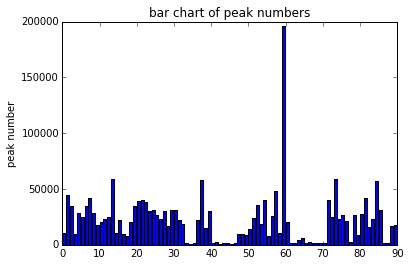

In [6]:
peak_number_dic=dict(peaks_number)
import matplotlib.pyplot as plt
%matplotlib inline 
p1 = plt.bar(peak_number_dic.keys(), peak_number_dic.values(), color='b')
plt.ylabel('peak number')
plt.title('bar chart of peak numbers')

In [7]:
avg_peak=np.average(peak_number_dic.values())
print "average peak number per song is %s" %avg_peak

average peak number per song is 22120.9888889


## Hashing the peaks for each song

In [8]:
peaks_sorted=peaks.map(lambda x: (x[0],sorted(zip(x[1][1],x[1][0]))))

In [9]:
import hashlib

# Generate a hashed relative peak value less than 200 frames apart
def hash_two_close_peaks(time1, freq1, time2, freq2,reduction=0):
    return hashlib.sha1("{}:{}:{}".format(time2 - time1, freq2, freq1)).hexdigest()[:(40-reduction)]

def hashed_pairs(x,r):
    hashed=[]
    tuples=x[1]
    idx=x[0]
    s=1
    N=len(tuples)
    for i in range(0,N-1):
        for j in range(s,N):
            if tuples[j][0]-tuples[i][0]>200:
                break
        s=j
        for k in range(i+1,s):
            pair=hash_two_close_peaks(tuples[i][0], tuples[i][1], tuples[k][0], tuples[k][1] ,reduction=r)
            hashed.append((idx,pair))
    return hashed

### 

### Compute the number of hashes for each song

In [10]:
import time
ptm=time.time()
hashed_pair_peak=peaks_sorted.flatMap(lambda x: hashed_pairs(x,0))
hash_counts=hashed_pair_peak.map(lambda x: (x[0],1)).reduceByKey(lambda a, b: a + b).collect()
time_used=time.time()-ptm

print "time used for counting is %s s" %time_used

time used for counting is 352.439282894 s


In [17]:
hashed_pair_peak.take(1)

[(0, 'bcd302010fc308fa5d52a1407ad9e4e89b091118')]

In [18]:
hash_counts

[(0, 283726),
 (1, 1700699),
 (2, 1227684),
 (3, 243994),
 (4, 882018),
 (5, 801217),
 (6, 1058949),
 (7, 1378221),
 (8, 802561),
 (9, 665906),
 (10, 669569),
 (11, 835173),
 (12, 1070820),
 (13, 1908833),
 (14, 344915),
 (15, 833475),
 (16, 313606),
 (17, 275059),
 (18, 661109),
 (19, 1058949),
 (20, 1172676),
 (21, 1268611),
 (22, 1153200),
 (23, 864014),
 (24, 988354),
 (25, 828199),
 (26, 787241),
 (27, 1197972),
 (28, 660150),
 (29, 1152030),
 (30, 1129807),
 (31, 812156),
 (32, 708532),
 (33, 47419),
 (34, 35309),
 (35, 51848),
 (36, 775402),
 (37, 2018945),
 (38, 562832),
 (39, 1064849),
 (40, 25175),
 (41, 86624),
 (42, 34746),
 (43, 43046),
 (44, 34154),
 (45, 20817),
 (46, 58175),
 (47, 290043),
 (48, 352886),
 (49, 242169),
 (50, 478755),
 (51, 1029740),
 (52, 1378077),
 (53, 697833),
 (54, 1749035),
 (55, 229747),
 (56, 706399),
 (57, 1389329),
 (58, 319487),
 (59, 6450190),
 (60, 484735),
 (61, 33468),
 (62, 71311),
 (63, 151450),
 (64, 244431),
 (65, 66427),
 (66, 90618),

### Group the hashed pair by peaks

In [19]:
hashed_pair_peak=peaks_sorted.flatMap(lambda x: hashed_pairs(x,0))
grouped_hash=hashed_pair_peak.map(lambda x: (x[1],x[0])).groupByKey()
grouped_hash_list=grouped_hash.map(lambda x: (x[0], list(x[1])))

In [20]:
grouped_hash_list.take(1)

[('ac8caba871ad0921f27bb513776396ec0577d799', [24, 33])]

## Count the number of peaks shared by each pair of songs

In [21]:
dic_pair={}
for i in range(0,89):
    if i<88:
        for j in range(i+1,90):
            pair=(i,j)
            dic_pair[pair]=0
    else:
        pair=(88,89)
        dic_pair[pair]=0

In [22]:
import itertools
def generate_pairs(x):
    d={}
    for j in x:
        d[j]=0
    thelist=[]
    for a,b in itertools.combinations(d,2):
        thelist.append((a,b))
    return thelist

In [24]:
def count_pairs(dic,x):
    for k in dic.keys():
        dic[k]=0
    for p in x:
        if p[0]>p[1]:
            p=(p[1],p[0])
            dic[p]=1
        else:
            dic[p]=1
    return dic    

In [25]:
import math
def add_dic(x,y):
    d={}
    for k in dic_pair:
        d[k]=x[k]+y[k]
    return d

In [26]:
grouped_hash_pair_songs=grouped_hash_list.map(lambda x: (x[0],generate_pairs(x[1])))
hash_pair_count=grouped_hash_pair_songs.map(lambda x: count_pairs(dic_pair,x[1])).reduce(lambda a,b: add_dic(a,b))

### Display the number of common peaks for each pair of songs

In [27]:
import operator
sorted_counts = sorted(hash_pair_count.items(), key=operator.itemgetter(1), reverse=True)
sorted_counts

[((54, 59), 381456),
 ((59, 73), 352052),
 ((1, 59), 331962),
 ((59, 84), 327747),
 ((6, 19), 304204),
 ((51, 59), 296845),
 ((74, 83), 294083),
 ((54, 73), 284283),
 ((1, 73), 282834),
 ((27, 59), 266435),
 ((1, 84), 262914),
 ((37, 59), 258605),
 ((59, 80), 253530),
 ((54, 84), 251062),
 ((7, 59), 249661),
 ((1, 54), 247587),
 ((73, 84), 246857),
 ((59, 81), 245313),
 ((51, 54), 242787),
 ((22, 59), 240264),
 ((20, 59), 230796),
 ((37, 78), 227748),
 ((15, 59), 226031),
 ((59, 72), 225627),
 ((24, 59), 223843),
 ((13, 59), 223516),
 ((53, 59), 222690),
 ((1, 81), 221972),
 ((54, 80), 220897),
 ((37, 84), 217064),
 ((21, 59), 215573),
 ((12, 59), 214622),
 ((1, 37), 214587),
 ((51, 73), 213839),
 ((19, 59), 213057),
 ((6, 59), 213057),
 ((52, 59), 210133),
 ((81, 84), 209347),
 ((51, 84), 208822),
 ((4, 59), 207569),
 ((13, 84), 203284),
 ((7, 54), 202254),
 ((30, 59), 201777),
 ((23, 59), 200968),
 ((37, 81), 200763),
 ((31, 59), 200365),
 ((73, 81), 200331),
 ((57, 59), 197554),
 ((

### It will likely cause problems by using the raw counts of common peak, as each song has different length, so the number of peaks. In this case, since the number of common peak is quite large, I am inclinded to use the log-ratio of common peaks as similar distance.

In [28]:
import math
hash_norm_count={}
for k in hash_pair_count.keys():
    hash_norm_count[k]=math.log(hash_pair_count[k])-math.log(max(hash_counts[k[0]][1],hash_counts[k[1]][1]))

In [29]:
import operator
sorted_hash_norm_count=sorted(hash_norm_count.items(), key=operator.itemgetter(1), reverse=True)
sorted_hash_norm_count

[((74, 83), -0.8685374241882471),
 ((6, 19), -1.2473336568188547),
 ((51, 53), -1.7031974470709947),
 ((55, 64), -1.7403409939723957),
 ((47, 48), -1.741659339465226),
 ((44, 70), -1.7734959911950163),
 ((28, 53), -1.7949415044093318),
 ((32, 53), -1.8001413345496626),
 ((12, 51), -1.820377099673527),
 ((48, 50), -1.8204724344727836),
 ((47, 50), -1.8323438965398218),
 ((47, 49), -1.850691809380896),
 ((9, 53), -1.8929153168600639),
 ((62, 65), -1.8955926359401083),
 ((53, 74), -1.8973444756922149),
 ((53, 83), -1.8973444756922149),
 ((51, 72), -1.8982730438585023),
 ((14, 58), -1.911629252189032),
 ((53, 82), -1.9122416315674897),
 ((51, 80), -1.928369243456693),
 ((53, 72), -1.9291019298301872),
 ((15, 51), -1.9317203165389643),
 ((9, 28), -1.9361755232012214),
 ((14, 79), -1.9421208282486226),
 ((25, 53), -1.94504961521781),
 ((22, 51), -1.9461946154572392),
 ((1, 54), -1.9550574508601972),
 ((15, 25), -1.974084625416591),
 ((51, 54), -1.9746349705114472),
 ((6, 51), -1.976642500652

In [30]:
import numpy as np
count_data=np.zeros((90,90))
for k in hash_pair_count.keys():
    count_data[k[0],k[1]]=hash_norm_count[k]
    count_data[k[1],k[0]]=hash_norm_count[k]

## Pairwise Distance Matrix 

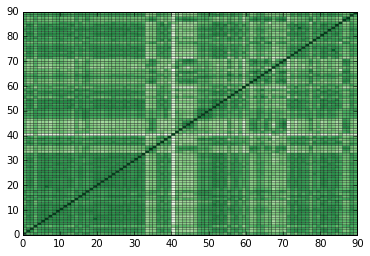

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.pcolor(count_data,cmap=plt.cm.Greens,edgecolor='k')
#plt.xticks(np.arange(0,90))
#plt.yticks(np.arange(0,90))
plt.show()
plt.close()

## Conclusion

From the log-ratio of common peaks, I find [74,83] and [6,19] are identical.